In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import warnings
from sklearn.svm import SVC


In [2]:
data = pd.read_csv('creditcard.csv')

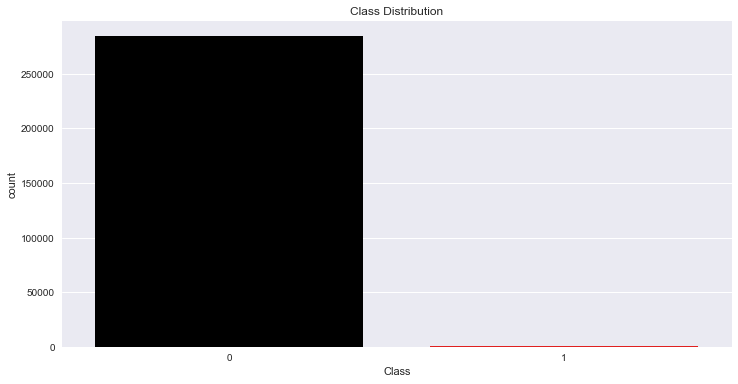

('% of normal transacation       :', 99)
('Number of normal transaction   :', 284315)
('% of fraud transacation        :', 0)
('Number of fraud transaction    :', 492)


In [3]:
my_pal = {0: 'black', 1: 'red'}

plt.figure(figsize = (12, 6))
ax = sns.countplot(x = 'Class', data = data, palette = my_pal)
plt.title('Class Distribution')
plt.show()

# Count and %
Count_Normal_transacation = len(data[data['Class']==0])
Count_Fraud_transacation = len(data[data['Class']==1]) 
Percentage_of_Normal_transacation = Count_Normal_transacation*100/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of normal transacation       :', Percentage_of_Normal_transacation)
print('Number of normal transaction   :', Count_Normal_transacation)
Percentage_of_Fraud_transacation= Count_Fraud_transacation*100/(Count_Normal_transacation+Count_Fraud_transacation)
print('% of fraud transacation        :',Percentage_of_Fraud_transacation)
print('Number of fraud transaction    :', Count_Fraud_transacation)

In [4]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data1 = data.drop(['Time','Amount'],axis=1)
data1.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [11]:
def show_metrics():
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    accuracy = float((float(tp+tn))/float(tp+tn+fp+fn))
    precision = float(float(tp)/float((tp+fp)))
    recall = float(float(tp)/float((tp+fn)))
    f1score = float(float(2*precision*recall)/float(precision+recall))
    print('Accuracy    =     {:.3f}'.format(accuracy))
    print('Precision =     {:.3f}'.format(precision))
    print('Recall    =     {:.3f}'.format(recall))
    print('F1_score  =     {:.3f}'.format(f1score))
    return accuracy, precision, recall, f1score

In [6]:
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();

In [7]:
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'k--', linewidth = 2)
    plt.xlim([0.0,0.001])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();

In [8]:
y = np.array(data1.Class.tolist())
data2 = data1.drop('Class', 1)
X = np.array(data2.as_matrix())

from sklearn.cross_validation import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))


/Users/dhruvkedia/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


('Number transactions train dataset: ', 199364)
('Number transactions test dataset: ', 85443)
('Total number of transactions: ', 284807)


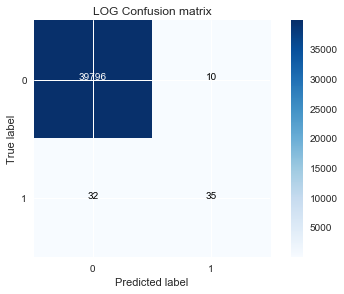

Accuracy    =     0.999
Precision =     0.778
Recall    =     0.522
F1_score  =     0.625


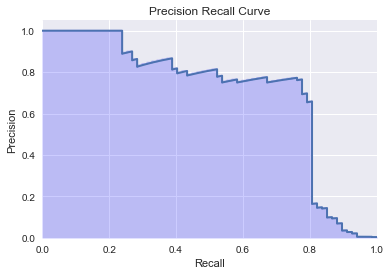

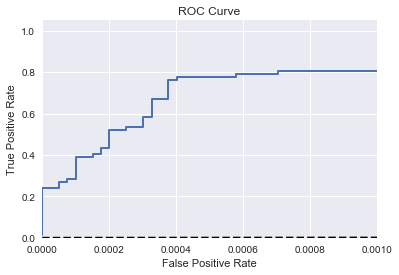

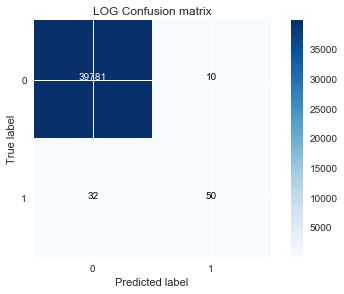

Accuracy    =     0.999
Precision =     0.833
Recall    =     0.610
F1_score  =     0.704


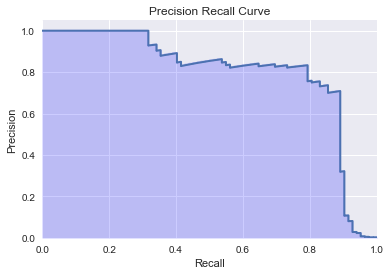

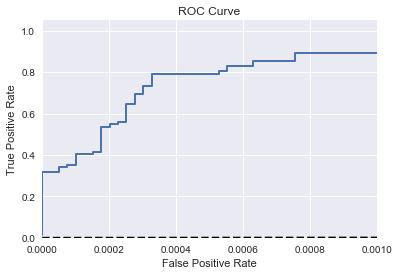

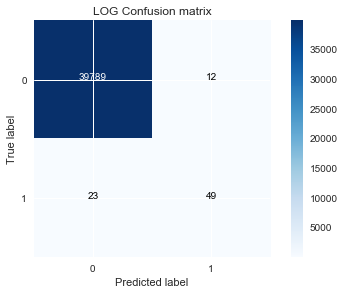

Accuracy    =     0.999
Precision =     0.803
Recall    =     0.681
F1_score  =     0.737


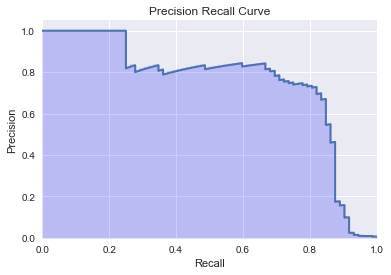

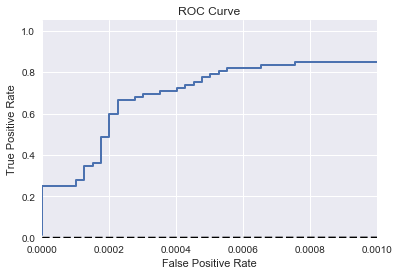

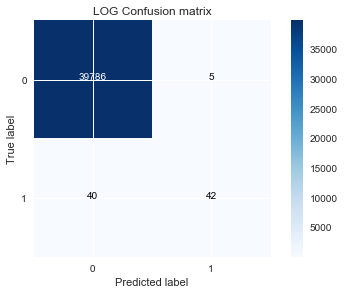

Accuracy    =     0.999
Precision =     0.894
Recall    =     0.512
F1_score  =     0.651


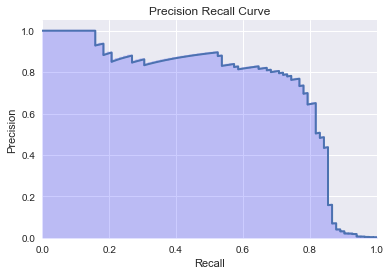

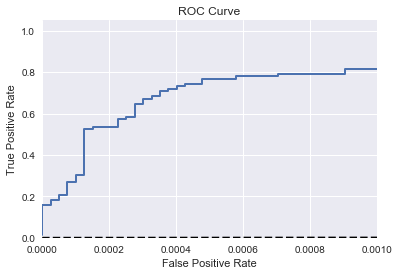

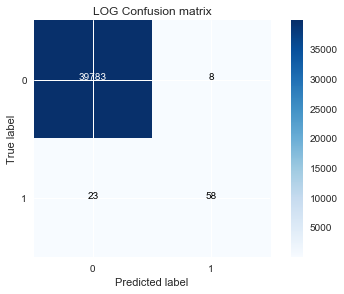

Accuracy    =     0.999
Precision =     0.879
Recall    =     0.716
F1_score  =     0.789


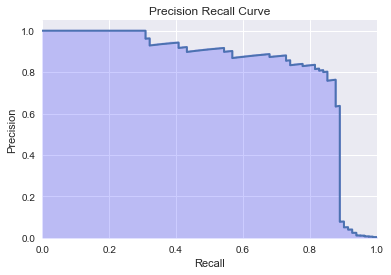

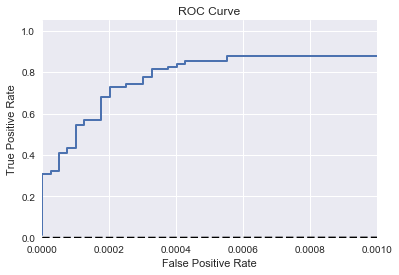

Mean Accuracy    =     0.999
Mean Precision =     0.837
Mean Recall    =     0.608
Mean F1_score  =     0.701


In [12]:
accuracies = []
precisions = []
recalls = []
f1scores = []
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for train_index, test_index in skf.split(X_train, y_train):
    X_train1, y_train1 = X[train_index], y[train_index]
    X_test1, y_test1 = X[test_index], y[test_index]
    log_cfl = LogisticRegression()

    log_cfl.fit(X_train1, y_train1)
    y_pred = log_cfl.predict(X_test1)
    y_score = log_cfl.decision_function(X_test1)  

    # Confusion maxtrix & metrics
    cm = confusion_matrix(y_test1, y_pred)
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cm, 
                          classes = class_names, 
                          title = 'LOG Confusion matrix')
    plt.show()
    accuracy, precision, recall, f1score= show_metrics()
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1score)
     # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test1, y_score)
    plot_precision_recall()
    fpr, tpr, t = roc_curve(y_test1, y_score)
    plot_roc()
   
    
accuracies = np.array(accuracies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1scores = np.array(f1scores)
print('Mean Accuracy    =     {:.3f}'.format(np.mean(accuracies)))
print('Mean Precision =     {:.3f}'.format(np.mean(precisions)))
print('Mean Recall    =     {:.3f}'.format(np.mean(recalls)))
print('Mean F1_score  =     {:.3f}'.format(np.mean(f1scores)))

In [18]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn import discriminant_analysis

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.svm import SVC

from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
import itertools
from itertools import cycle

from sklearn import discriminant_analysis

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


# Any results you write to the current directory are saved as output.

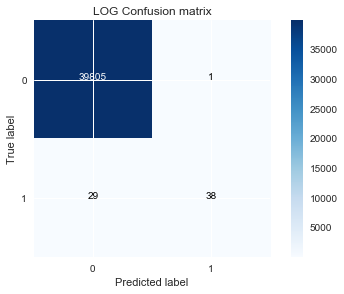

Accuracy    =     0.999
Precision =     0.974
Recall    =     0.567
F1_score  =     0.717


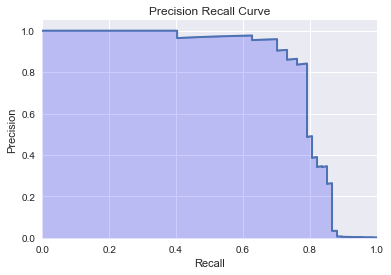

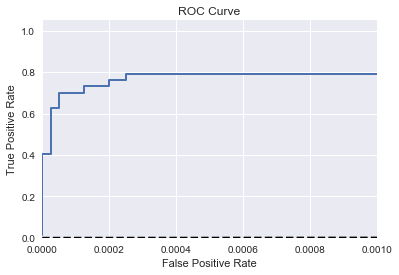

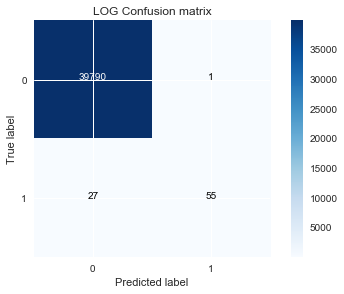

Accuracy    =     0.999
Precision =     0.982
Recall    =     0.671
F1_score  =     0.797


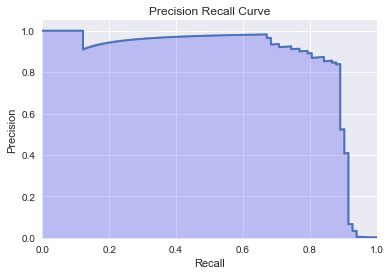

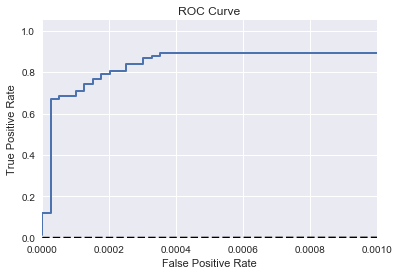

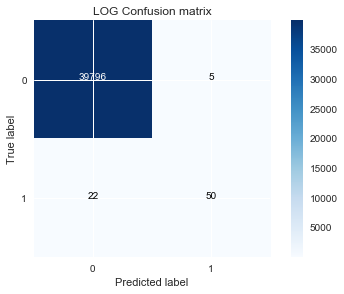

Accuracy    =     0.999
Precision =     0.909
Recall    =     0.694
F1_score  =     0.787


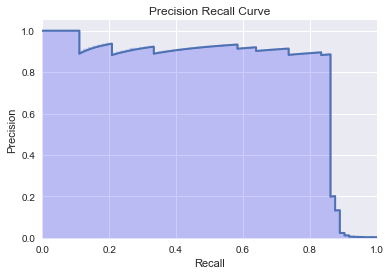

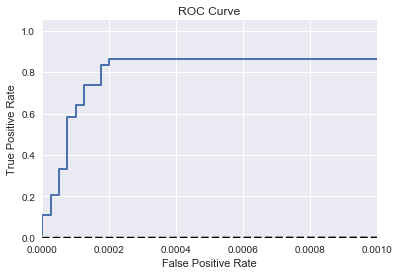

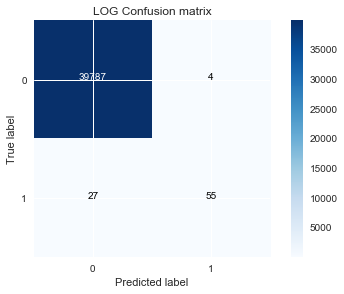

Accuracy    =     0.999
Precision =     0.932
Recall    =     0.671
F1_score  =     0.780


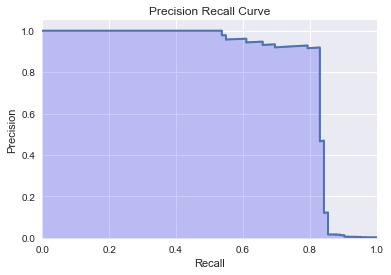

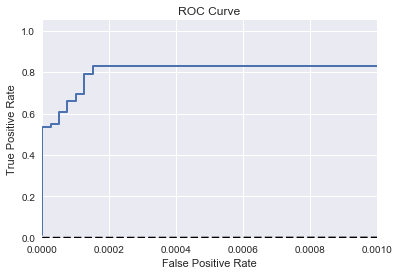

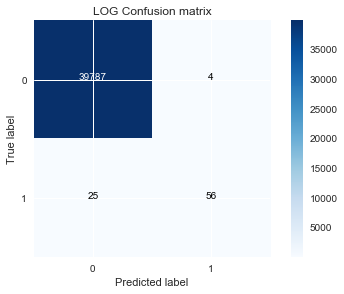

Accuracy    =     0.999
Precision =     0.933
Recall    =     0.691
F1_score  =     0.794


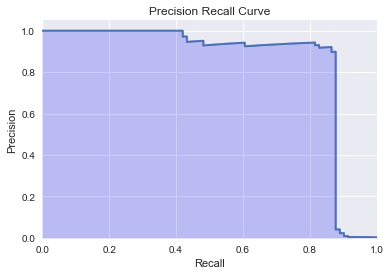

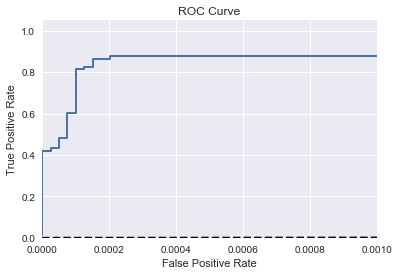

Mean Accuracy    =     0.999
Mean Precision =     0.946
Mean Recall    =     0.659
Mean F1_score  =     0.775


In [13]:
accuracies = []
precisions = []
recalls = []
f1scores = []
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
tuned_parameters = [{'kernel': ['rbf','poly'], 'gamma': [1e-3,  1e-4], 'C': [1,10,100,1000]}]

for train_index, test_index in skf.split(X_train, y_train):
    X_train1, y_train1 = X[train_index], y[train_index]
    X_test1, y_test1 = X[test_index], y[test_index]
    svm = SVC()
    svm.fit(X_train1, y_train1)

    y_pred = svm.predict(X_test1)
    y_score = svm.decision_function(X_test1)  

    # Confusion maxtrix & metrics
    cm = confusion_matrix(y_test1, y_pred)
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cm, 
                          classes = class_names, 
                          title = 'LOG Confusion matrix')
    plt.show()
    accuracy, precision, recall, f1score= show_metrics()
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1scores.append(f1score)
     # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test1, y_score)
    plot_precision_recall()
    fpr, tpr, t = roc_curve(y_test1, y_score)
    plot_roc()
   
    
accuracies = np.array(accura cies)
precisions = np.array(precisions)
recalls = np.array(recalls)
f1scores = np.array(f1scores)
print('Mean Accuracy    =     {:.3f}'.format(np.mean(accuracies)))
print('Mean Precision =     {:.3f}'.format(np.mean(precisions)))
print('Mean Recall    =     {:.3f}'.format(np.mean(recalls)))
print('Mean F1_score  =     {:.3f}'.format(np.mean(f1scores)))